In [1]:
import torch

from model import *
from data import *
from vis import *
import gc

import itertools

In [2]:
config = Config().load("GCLSTMConfig.json")

In [3]:
def splitDataset(dataset, trainSplit=0.8, shuffle=True):
    trainSize = len(dataset)
    # TODO: More stratified subsets using dataset.lengths and geographic information
    train = torch.utils.data.Subset(dataset, range(int(trainSize * trainSplit)))
    test = torch.utils.data.Subset(dataset, range(int(trainSize * trainSplit), trainSize))

    trainSampler = GraphSizeSampler(train, nodesPerBatch=config.nodesPerBatch, force=False, shuffle=shuffle)
    testSampler = GraphSizeSampler(test, nodesPerBatch=config.nodesPerBatch, force=False, shuffle=shuffle)

    train = DataLoader(train, batch_sampler=trainSampler, generator=torch.Generator(device))
    test = DataLoader(test, batch_sampler=testSampler, generator=torch.Generator(device))

    return train, test

In [4]:
def itertoolsBetter(dataIter):
    while True:
        for batch in dataIter:
            yield batch


def trainModel(config, modelClass, dataClass, objective, epochs, criterion: dict[str: nn.Module]):
    model = None
    dataset = None
    try:
        dataset = dataClass(config)

        dataset.info(dataset[0])

        train, test = splitDataset(dataset, config.dataSplit)

        batch1 = next(iter(train))
        dataset.info(batch1)
        dataset.display(batch1)

        model = modelClass(config)
        print(f"Model has {sum([p.numel() for p in model.parameters()])} parameters")
        print(f"Dataset has {len(dataset)} samples")
        print(next(model.parameters()).is_cuda)

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        testIter = itertoolsBetter(test)

        client = Client("127.0.0.1", 12945)

        for epoch in range(epochs):
            progress = 0
            for inputs, targets in train:
                model.train()
                optimizer.zero_grad()

                metrics = {}

                history, future = targets.dischargeHistory, targets.dischargeFuture
                thresholds, means, deviations = targets.thresholds, targets.mean.unsqueeze(-1), targets.deviation.unsqueeze(-1)
                hindcast, forecast = model(inputs)
                loss = objective(forecast, future)

                for eval in criterion:
                    evaluated = criterion[eval](forecast, future, thresholds=thresholds, means=means, deviations=deviations)
                    metrics["Train " + eval] = evaluated

                # TODO: Determine source of nans
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"\nNAN FOUND IN LOSS")
                    dataset.info((inputs, targets))
                    print("\n")

                    optimizer.zero_grad()
                    torch.cuda.empty_cache()
                    continue

                trainLoss = loss.detach().item()

                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
                torch.nn.utils.clip_grad_value_(model.parameters(), 10)

                optimizer.step()

                torch.cuda.empty_cache()

                with torch.no_grad():
                    model.eval()
                    inputs1, targets1 = next(testIter)

                    history1, future1 = targets1.dischargeHistory, targets1.dischargeFuture
                    thresholds1, means1, deviations1 = targets1.thresholds, targets1.mean.unsqueeze(-1), targets1.deviation.unsqueeze(-1)
                    hindcast1, forecast1 = model(inputs1)
                    loss1 = objective(forecast1, future1)
                    testLoss = loss1.detach().item()

                    for eval in criterion:
                        evaluated = criterion[eval](forecast1, future1, thresholds=thresholds1, means=means1, deviations=deviations1)
                        metrics["Test " + eval] = evaluated

                if (progress + 1) % 10 == 0:
                    gc.collect()

                client.send("Train Loss", trainLoss)
                client.send("Test Loss", testLoss)

                for metric in metrics:
                    client.send(metric, metrics[metric])

                progress += 1

                print(f"\r{progress}/{len(train)} | {(progress / len(train)) * 100:.3f}% |  Train Loss: {trainLoss:.2f} | Test Loss: {testLoss:.2f} | Memory: {torch.cuda.memory_allocated()}", end="")
            print()

        return model, dataset

    except KeyboardInterrupt:
        if model is not None:
            torch.save(model.state_dict(), "checkpoint.pt")
        return model, dataset

Loading GeoPandas...
GeoPandas Loaded
2544/2544 GRDC files loaded
9640/9640 ERA5 files loaded
Total empty basins: 37
57622/57646 Basin Structures Appended to Graph
Upstream Basins Compiled | 1.0 | 17.43485477178423
Upstream Structures Compiled
Structure Tensors Complete
Index Mapping Complete
Static Input Scaling Complete

        Total Samples: 29465001
        Era5 History: torch.Size([1, 30, 7]) torch.float32 -40.65220260620117 125.16150665283203
        Era5 Future: torch.Size([1, 7, 7]) torch.float32 -17.33765411376953 828.5452270507812 
        Basin Continuous: torch.Size([1, 277]) torch.float32 -0.8782722353935242 4.530961990356445 
        Basin Discrete: torch.Size([1, 10]) torch.int64 3 587 
        Structure: torch.Size([2, 1]) torch.int64 0 0 
        River Continuous: torch.Size([258]) torch.float32 -2.1314620971679688 6.499033451080322 
        River Discrete: torch.Size([14]) torch.int64 0 2 
        Discharge History: torch.Size([30]) torch.float32 0.7660790085792542 0

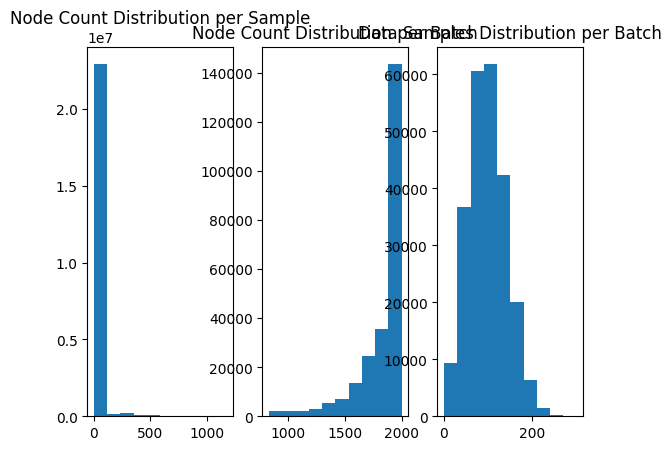

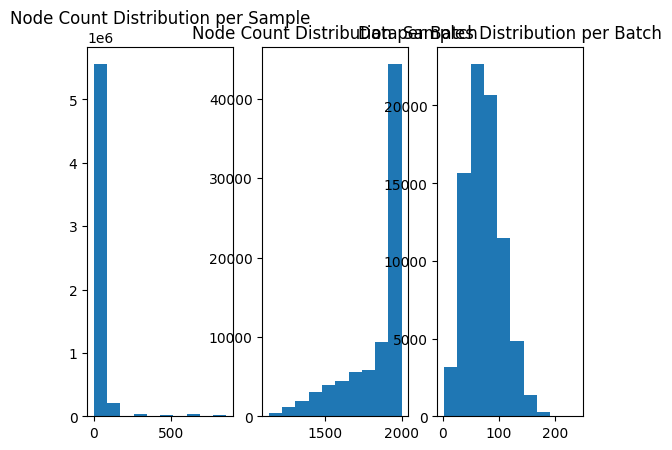


        Total Samples: 29465001
        Era5 History: torch.Size([2000, 30, 7]) torch.float32 -12075.873046875 18453.158203125
        Era5 Future: torch.Size([2000, 7, 7]) torch.float32 -11123.5068359375 39873.15234375 
        Basin Continuous: torch.Size([2000, 277]) torch.float32 -3.5847716331481934 19.868215560913086 
        Basin Discrete: torch.Size([2000, 10]) torch.int64 0 732 
        Structure: torch.Size([2, 3937]) torch.int64 0 1999 
        River Continuous: torch.Size([63, 258]) torch.float32 -2.7134768962860107 18.18232536315918 
        River Discrete: torch.Size([63, 14]) torch.int64 0 110 
        Discharge History: torch.Size([63, 30]) torch.float32 -3.9346585273742676 10.07571029663086 
        Discharge Future: torch.Size([63, 7]) torch.float32 -3.9346585273742676 6.321659564971924 
        Thresholds: torch.Size([63, 4]) torch.float32 -2.7246599197387695 0.7352085113525391 
        Deviation: torch.Size([63]) torch.float32 10.417177200317383 4020.28076171875 
 

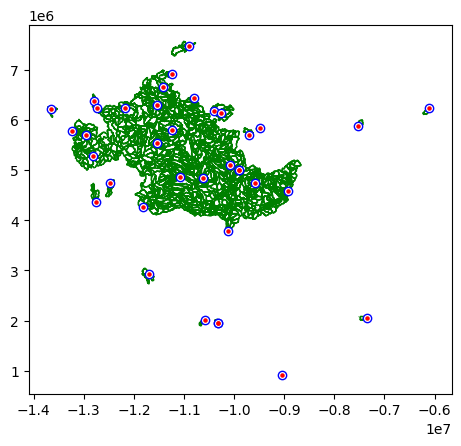

Model has 303096 parameters
Dataset has 29465001 samples
True
10722/238864 | 4.489% |  Train Loss: 3.03 | Test Loss: 18.72 | Memory: 50233528324

ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

In [5]:
metrics = {
    "NMAE": CMALNormalizedMeanAbsolute(),
    "1 Year Flood Precision": CMALPrecision(batches=20),
    "1 Year Flood Recall": CMALRecall(batches=20),
    "KGE": CMALKGE(),
    "NSE": CMALNSE(),
    "Uncertainty": CMALUncertainty()
}

model, dataset = trainModel(config, InundationGCLSTMStation, InundationData, CMALLoss(), epochs=10, criterion=metrics)

In [ ]:
def evalModel(config, model, dataset):
    model.eval()
    _, test = splitDataset(dataset, config.dataSplit, shuffle=True)

    metrics = {}

    progress = 0

    with torch.no_grad():
        try:
            for inputs, targets in test:
                history, future = targets.dischargeHistory, targets.dischargeFuture
                thresholds, deviations = targets.thresholds, targets.deviation.unsqueeze(-1)
                hindcast, forecast = model(inputs)

                # Consider sampling?
                medianPrediction = torch.sum(forecast[0] * forecast[3], dim=-1)
                mae = torch.abs(medianPrediction - future)

                medianPrediction = medianPrediction.unsqueeze(-1)
                future = future.unsqueeze(-1)
                thresholds = thresholds.unsqueeze(1).expand(-1, config.future, -1)
                tp = (medianPrediction > thresholds).float() * (future > thresholds).float()
                fp = (medianPrediction > thresholds).float() * (future < thresholds).float()
                fn = (medianPrediction < thresholds).float() * (future > thresholds).float()

                past, _ = inputs
                for n, name in enumerate(past.grdcID):
                    if name not in metrics:
                        metrics[name] = {
                            "iter": 0,
                            "mae": torch.zeros([config.future]),
                            "tp": torch.zeros([config.future, thresholds.shape[-1]]),
                            "fp": torch.zeros([config.future, thresholds.shape[-1]]),
                            "fn": torch.zeros([config.future, thresholds.shape[-1]]),
                            "nodes": past.nodes[n],
                            # TODO: Calculate size of upstream basin GRDC -> PFAF -> Upstream -> Sum
                            "size": None
                        }

                    metrics[name]["mae"] = (metrics[name]["mae"] * metrics[name]["iter"] + mae[n]) / (metrics[name]["iter"] + 1)
                    metrics[name]["tp"] += tp[n]
                    metrics[name]["fp"] += fp[n]
                    metrics[name]["fn"] += fn[n]
                    metrics[name]["iter"] += 1

                progress += 1
                print(f"\r{progress}/{len(test)} | {(progress / len(test)) * 100:.2f}% Complete", end="")
        except KeyboardInterrupt:
            pass

    nodeX, nodeY = np.zeros([len(metrics), 4]), np.zeros([len(metrics), 4])
    precisionBox, recallBox, f1Box = np.zeros([len(metrics), config.future, 4]), np.zeros([len(metrics), config.future, 4]), np.zeros([len(metrics), config.future, 4])
    for i, name in enumerate(metrics):
        print(name)
        print(metrics[name]["nodes"].cpu().numpy())
        nodeX[i, :] = metrics[name]["nodes"].cpu().numpy()

        tp = metrics[name]["tp"]
        fp = metrics[name]["fp"]
        fn = metrics[name]["fn"]

        print(torch.sum(tp), torch.sum(fp), torch.sum(fn))

        recall = tp / (tp + fn)
        precision = tp / (tp + fp)

        f1 = 2 * recall * precision / (recall + precision)

        nodeY[i, :] = torch.mean(f1, dim=0).cpu().numpy()

        print(precision.shape)
        print(recall.shape)
        print(f1.shape)

        precisionBox[i] = precision.cpu().numpy()
        recallBox[i] = recall.cpu().numpy()
        f1Box[i] = f1.cpu().numpy()

    print(f1Box.shape, np.max(f1Box), np.min(f1Box))

    labels = ["1 Year Return Period", "2 Year Return Period", "5 Year Return Period", "10 Year Return Period"]
    colors = ["blue", "green", "yellow", "orange"]
    for i in range(4):
        plt.subplot(2, 4, i + 1)
        plt.title(labels[i])
        currentX = nodeX[:, i]
        currentY = nodeY[:, i]
        mask = ~np.isnan(currentY)
        currentX, currentY = currentX[mask], currentY[mask]
        plt.scatter(currentX, currentY, alpha=0.3, c=colors[i])

        plt.grid()
        plt.xlabel("Total Upstream Basin Nodes")
        plt.ylabel("F1 Score")

    for i in range(4):
        plt.subplot(2, 4, i + 5)
        plt.title(labels[i])
        currentF1 = f1Box[:, :, i]
        currentF1 = [box[~np.isnan(box)] for box in currentF1]
        plt.boxplot(currentF1)

        plt.grid()
        plt.xlabel("Forecast Horizon")
        plt.ylabel("F1 Score")

    plt.show()

    # TODO: Evaluate metrics against basin size, nodes in graph, find other correlations in basin characteristics
    # TODO: Evaluate on more stratified data (other continents?)
    # TODO: Maybe evaluate at New Madrid for fun

In [ ]:
evalModel(config, model, dataset)